In [1]:
import matplotlib
#matplotlib.use('Agg')
%matplotlib tk
%autosave 180
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


Autosaving every 180 seconds


In [2]:
from moviepy.editor import VideoFileClip
import numpy as np
from pathlib import Path
from skimage.util import img_as_ubyte
import tensorflow as tf
import tensorflow.contrib.slim as slim
#import tf_slim as slim
from tqdm import tqdm
import yaml
from deeplabcut.pose_estimation_tensorflow.nnet.net_factory import pose_net
from util import create_annotated_movie, get_train_config
from deeplabcut.pose_estimation_tensorflow.nnet.pose_net import prediction_layer
from deeplabcut.utils import auxiliaryfunctions

vers = tf.__version__.split('.')
if int(vers[0]) == 1 and int(vers[1]) > 12:
    TF = tf.compat.v1
else:
    TF = tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:

# %% util functions
def calculate_peaks(numparts, heatmap_avg):
    # Right now there is a score for every part since some parts are likely to need lower thresholds.
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        ##logger.ERROR('Not enough scores provided for number of parts')
        # return
    # threshold_detection = params['thre1']
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[:, :, part]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks


def zero2nan(x):
    x1 = np.copy(x)
    x1[np.sum(x, 1) == 0, :] = np.nan
    return x1


def temporal_filter_first(markers, na, adds):
    # filter the traces for the first time
    markers_temp = np.copy(markers)
    markers_filter = np.copy(markers_temp)
    end_frame = markers_temp.shape[0]
    wt_bound = 20  # upper bound of the distance that a marker can move between two frames
    cl_bound = 0.7  # lower bound of the confidence level
    part_id = 0
    for animal_id in range(na + adds):  #
        marker_previous = markers_temp[0, animal_id, 0, :]
        for frame_id in range(1, end_frame):
            cl = markers_cen[frame_id, :, :, 0]  # confidence level

            marker_current = markers_temp[frame_id, :, part_id, :]
            marker_current = zero2nan(marker_current)  # set zeros to nans

            marker_previous1 = marker_previous.reshape(1, -1)
            marker_previous1 = zero2nan(marker_previous1)[0]  # set zeros to nans

            move_marker = []
            for marker_i in marker_current:
                move_marker_i = np.sqrt(np.sum((marker_i[1:] - marker_previous1[1:]) ** 2))
                move_marker += [np.sum(move_marker_i)]
            move_marker = np.array(move_marker)
            move_marker[np.isnan(move_marker)] = 1e10  # if the movement is nan, set it to be 1e10
            move_marker_valid_ind = np.where(move_marker <= wt_bound)[0]  # pick the ids whose movement is below wt_bound
            if len(move_marker_valid_ind) == 0:  # if all movements are not valid
                marker_i = marker_previous1
            else:
                cl_valid = cl[move_marker_valid_ind]
                cl_valid_ind = np.where(cl_valid > cl_bound)[0]
                if len(cl_valid_ind) == 0:  # if all of the confidence levels are below 0.7, pick the id with the highest confidence level
                    selected_id = np.argmax(cl_valid)
                    selected_id = move_marker_valid_ind[selected_id]
                else:  # for all confidence levels which are above 0.7, pick the id with the smallest movement
                    move_marker_valid_cl = move_marker_valid_ind[cl_valid_ind]
                    move_marker_valid_cl_ind = move_marker[move_marker_valid_cl]
                    selected_id = np.argmin(move_marker_valid_cl_ind)
                    selected_id = move_marker_valid_cl[selected_id]

                marker_i = marker_current[selected_id, :]
                markers_temp[frame_id, selected_id, part_id, :] = np.nan  # set the identity to be nan if it's already selected

            marker_previous = np.copy(marker_i)
            markers_filter[frame_id, animal_id, part_id, :] = marker_i

    return markers_filter


def temporal_filter_second(markers, na, adds):
    # filter the traces for the second time
    markers_filter = np.copy(markers)
    end_frame = markers_filter.shape[0]
    wt_bound = 20
    cl_bound = 0.7  # lower bound of the confidence level
    part_id = 0
    marker_previous = markers_filter[0, :, part_id, :]
    candidate_id = -np.ones((na + adds, na + adds))
    candidate_id[:, 0] = np.linspace(0, na + adds - 1, na + adds).astype(np.int32)
    candidate_move = candidate_id * 0
    for frame_id in range(1, end_frame):
        cl = markers[frame_id, :, :, 0]
        candidate_id_new = candidate_id.copy()
        for animal_id in range(na + adds):  # [0,1]:#
            marker_current = markers[frame_id, :, part_id, :]
            marker_current = zero2nan(marker_current)  # set zeros to nans

            marker_previous1 = marker_previous[animal_id, :].reshape(1, -1)
            marker_previous1 = zero2nan(marker_previous1)[0]  # set zeros to nans

            move_marker = []
            for marker_i in marker_current:
                move_marker_i = np.sqrt(np.sum((marker_i[1:] - marker_previous1[1:]) ** 2))
                move_marker += [np.sum(move_marker_i)]
            move_marker = np.array(move_marker)
            move_marker[np.isnan(move_marker)] = 1e10  # if the movement is nan, set it to be 1e10
            move_marker_valid_ind = np.where(move_marker <= wt_bound)[0]  # pick the ids whose movement is below wt_bound
            if len(move_marker_valid_ind) > 0:  # if at least one of the movements is valid
                cl_valid = cl[move_marker_valid_ind]
                cl_valid_ind = np.where(cl_valid > cl_bound)[0]
                if len(cl_valid_ind) == 0:  # if all of the confidence levels are below 0.7, pick the id with the highest confidence level
                    selected_id_sortlist = np.argsort(-cl_valid)
                    selected_id_sortlist = move_marker_valid_ind[selected_id_sortlist]
                else:
                    move_marker_valid_cl = move_marker_valid_ind[cl_valid_ind]
                    move_marker_valid_cl_ind = move_marker[move_marker_valid_cl]
                    selected_id_sortlist = np.argsort(move_marker_valid_cl_ind)
                    selected_id_sortlist = move_marker_valid_cl[selected_id_sortlist]

                candidate_id[animal_id, :len(selected_id_sortlist)] = selected_id_sortlist.reshape(-1, )
                candidate_id[animal_id, len(selected_id_sortlist):] = -1

            # based on the candidate id list, make a candidate movement list
            candidate_move_list = move_marker * 0 + 1e10
            for can_j, can_move in enumerate(candidate_id[animal_id, :]):
                if can_move > -1:
                    candidate_move_list[can_j] = move_marker[int(can_move)]
            candidate_move[animal_id, :] = candidate_move_list

        # based on the movement from time t-1 to time t for each id, we can assign ids at t-1 to ids at t
        # we need to make sure: 1. each id at t-1 is only assigned to id at t once, making sure no two ids share the same id at t-1
        #                       2. when two ids at t compete for one id at t-1, the one with the smallest movement will get the assignment
        assigned_list = []
        unique_list = []
        # go over each column from left to right, left has the highest priority
        for c in range(candidate_id.shape[1]):
            candidate_column = candidate_id[:, c]

            # count the occurrence of each id in column c
            uniques, counts = np.unique(candidate_column, return_counts=True)

            # throw away -1
            u1 = np.where(uniques > -1)[0]
            uniques = uniques[u1]
            counts = counts[u1]

            # get the ids who only appear once
            unique_one = uniques[np.where(counts == 1)[0]]
            for uo in unique_one:
                if uo not in unique_list:
                    candidate_uo = np.where(candidate_column == uo)[0][0]
                    if candidate_uo not in assigned_list:
                        candidate_id_new[candidate_uo, :] = uo
                        assigned_list += [candidate_uo]

            # get the ids who appear twice or more
            unique_tm = uniques[np.where(counts > 1)[0]]
            for utm in unique_tm:
                if utm not in unique_list:
                    candidate_utm = np.where(candidate_column == utm)[0]
                    candidate_utm = list(candidate_utm)
                    candidate_move_c = candidate_move[:, c].copy()  # get the candidate movement in column c
                    candidate_move_c[assigned_list] = 1e10  # if one id is already assigned, set the move to be 1e10
                    candidate_move_utm = candidate_move_c[candidate_utm]
                    min_ind = np.argmin(candidate_move_utm)
                    candiate_utm_min = candidate_utm[min_ind]
                    if candiate_utm_min not in assigned_list:
                        candidate_id_new[candiate_utm_min, 0] = utm
                        assigned_list += [candiate_utm_min]

            unique_list += list(uniques)

        full_list = list(range(na + adds))
        not_assigned_list = [v for v in full_list if v not in assigned_list]

        assigned_id = candidate_id_new[assigned_list, 0]
        not_assigned_id = [v for v in full_list if v not in assigned_id]
        candidate_id_new[not_assigned_list, 0] = not_assigned_id
        candidate_id_new[:, 1:] = -1
        candidate_id = candidate_id_new

        marker_previous = marker_current[np.array(candidate_id[:, 0]).astype(np.int32), :]
        markers_filter[frame_id, :, part_id, :] = marker_previous

    return markers_filter

In [19]:
# %%
# snapshot from DLC
snapshot = 'snapshot-100000'
# project path
dlcpath = '/media/cat/4TBSSD/DLC_full_directory'
# the path to the test video
test_video = '/media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec.avi'

shuffle = 1
dlc_base_path = Path(dlcpath)
config_path = dlc_base_path / 'config.yaml'
print('config_path', config_path)
cfg = auxiliaryfunctions.read_config(config_path)
trainingsetindex = 0
modelfoldername = auxiliaryfunctions.GetModelFolder(
    cfg["TrainingFraction"][trainingsetindex], shuffle, cfg)

train_path = dlc_base_path / modelfoldername / 'train'
init_weights = str(train_path / snapshot)

# structure info
bodyparts = cfg['multianimalbodyparts']
skeleton = cfg['skeleton']
if skeleton is None:
    skeleton = []
S0 = np.zeros((len(skeleton), len(bodyparts)))
for s in range(len(skeleton)):
    sk = skeleton[s]
    ski = bodyparts.index(sk[0])
    skj = bodyparts.index(sk[1])
    S0[s, ski] = 1
    S0[s, skj] = -1

na = 4  # number of animals
nl = len(skeleton)
nj = len(bodyparts)

# %%
video_clip = VideoFileClip(test_video)
ny_in, nx_in = video_clip.size
n_frames = np.ceil(video_clip.fps * video_clip.duration).astype('int')
print('done')

# load dlc project config file
print('loading dlc project config...', end='')
with open(config_path, 'r') as stream:
    proj_config = yaml.safe_load(stream)
proj_config['video_path'] = None
dlc_cfg = get_train_config(proj_config, shuffle=1)
dlc_cfg.init_weights = init_weights
dlc_cfg.net_type = 'resnet_50'
print(dlc_cfg)
print('dlc_cfg.init_weights', dlc_cfg.init_weights)




config_path /media/cat/4TBSSD/DLC_full_directory/config.yaml
done
loading dlc project config.../media/cat/4TBSSD/DLC_full_directory/dlc-models/iteration-0/madeline_july2Jul2-trainset95shuffle1/train/pose_cfg.yaml
{'stride': 8.0, 'weigh_part_predictions': False, 'weigh_negatives': False, 'fg_fraction': 0.25, 'mean_pixel': [123.68, 116.779, 103.939], 'shuffle': True, 'snapshot_prefix': '/media/cat/4TBSSD/DLC_full_directory/dlc-models/iteration-0/madeline_july2Jul2-trainset95shuffle1/train/snapshot', 'log_dir': 'log', 'global_scale': 0.8, 'location_refinement': True, 'locref_stdev': 7.2801, 'locref_loss_weight': 0.05, 'locref_huber_loss': True, 'optimizer': 'adam', 'intermediate_supervision': False, 'intermediate_supervision_layer': 12, 'regularize': False, 'weight_decay': 0.0001, 'crop_pad': 0, 'scoremap_dir': 'test', 'batch_size': 8, 'dataset_type': 'multi-animal-imgaug', 'deterministic': False, 'mirror': False, 'pairwise_huber_loss': False, 'weigh_only_present_joints': False, 'partaffi

In [17]:

# %%
# -------------------
# define model
# -------------------
# sess, net, inputs = initialize_resnet(dlc_cfg, nx_in, ny_in)
TF.reset_default_graph()
inputs = TF.placeholder(tf.float32, shape=[None, None, None, 3])
pn = pose_net(dlc_cfg)

net, end_points = pn.extract_features(inputs)
scope = "pose"
reuse = None
heads = {}
with tf.variable_scope(scope, reuse=reuse):
    heads["part_pred"] = prediction_layer(
        dlc_cfg, net, "part_pred", nj
    )
    heads["locref"] = prediction_layer(
        dlc_cfg, net, "locref_pred", nj * 2
    )

    heads["pairwise_pred"] = prediction_layer(
        dlc_cfg, net, "pairwise_pred", nl * 2
    )
pred = heads['part_pred']

# restore from snapshot
variables_to_restore = slim.get_variables_to_restore(include=["resnet_v1"])
variables_to_restore1 = slim.get_variables_to_restore(include=["pose/part_pred"])
restorer = TF.train.Saver(variables_to_restore + variables_to_restore1)

# initialize tf session
config_TF = TF.ConfigProto()
config_TF.gpu_options.allow_growth = True
sess = TF.Session(config=config_TF)

# initialize weights
sess.run(TF.global_variables_initializer())
sess.run(TF.local_variables_initializer())

# restore resnet from dlc trained weights
restorer.restore(sess, dlc_cfg.init_weights)

# %% collect traces for test video
# -------------------
# extract pose
# -------------------
print('\n')
n_frames = 100
print ("overwrting # frames: ", n_frames)

pbar = tqdm(total=n_frames, desc='processing video frames')
adds = 10  # additional markers to be identified


markers = np.zeros((n_frames, na + adds, nj, 3))
centroid = 4  # pick the 7th marker as the centroid

for i in range(n_frames):

    if False:
        # scoop out the rock in each frame
        frame = video_clip.get_frame(i / video_clip.fps)
        ff = img_as_ubyte(frame)
        ws1 = 60
        ws2 = 40
        patch = [132, 1080]
        ff_mask = np.zeros((ff.shape))
        ff_mask[(patch[0] - ws1):(patch[0] + ws1), :, :] = ff_mask[(patch[0] - ws1):(patch[0] + ws1), :, :] + 1
        ff_mask[:, (patch[1] - ws2):(patch[1] + ws2), :] = ff_mask[:, (patch[1] - ws2):(patch[1] + ws2), :] + 1
        ff_mask = -np.sign(ff_mask - 2)
        ff = ff * ff_mask

        # feed to the network
        feed_dict = {inputs: ff[None, :, :, :]}
        [pred_s] = sess.run([pred], feed_dict=feed_dict)
        print ("pred:s", pred_s.shape)
        #break
    else:
        pred_s= predictions[i][None]
    
    
    nx_out = pred_s.shape[1]
    ny_out = pred_s.shape[2]
    sig_pred = 1 / (np.exp(-pred_s) + 1)  # confidence map

    # find peaks from the confidence map
    all_peaks = calculate_peaks(nj, sig_pred[0, :, :, :])
    for ind, peak_i in enumerate(all_peaks):
        if len(peak_i) > 0 and ind == centroid:
            peak_i = np.array(peak_i)
            peak_i1 = np.argsort(peak_i[:, 2])
            peak_i = peak_i[peak_i1, :]
            len_peak = len(peak_i)
            if len_peak < na + adds:
                peak_i = np.vstack((np.zeros((na + adds - len_peak, 4)), peak_i))
            peak_i = peak_i[(-na - adds):, :]
            peak_i = peak_i[:, :3]
            peak_i = np.flip(peak_i, 0)
            markers[i, :, ind, :] = peak_i

    pbar.update()

markers = np.flip(markers, 3)



Initializing ResNet








processing video frames:   0%|          | 0/100 [00:00<?, ?it/s]





processing video frames:  11%|█         | 11/100 [00:00<00:00, 103.05it/s]



overwrting # frames:  100








processing video frames:  23%|██▎       | 23/100 [00:00<00:00, 105.72it/s]





processing video frames:  35%|███▌      | 35/100 [00:00<00:00, 108.84it/s]





processing video frames:  47%|████▋     | 47/100 [00:00<00:00, 111.31it/s]





processing video frames:  59%|█████▉    | 59/100 [00:00<00:00, 112.63it/s]





processing video frames:  71%|███████   | 71/100 [00:00<00:00, 113.81it/s]





processing video frames:  83%|████████▎ | 83/100 [00:00<00:00, 114.58it/s]





processing video frames:  95%|█████████▌| 95/100 [00:00<00:00, 115.14it/s]

In [10]:
predictions = np.load('/media/cat/4TBSSD/DLC_full_directory/videos_to_label/predictions.npy')
print (predictions.shape)
print (markers.shape)
#print (markers[0])

(1000, 128, 160, 14)
(100, 14, 14, 3)


In [18]:

# %%
# filter the traces for the first time
print ("Filtering traces")
markers_cen = markers[:, :, centroid, None, :]
print ("markers_cen ", markers_cen.shape)
markers_filter = temporal_filter_first(markers_cen, na, adds)

# %% find the top na traces with the highest confidence levels
print ("Searching for highest confidence")
top_n = na
markers_filter_cl = np.mean(markers_filter, 0)
markers_filter_cl = np.squeeze(markers_filter_cl[:, :, 0])  # confidence level for each trace
argsort_ind = np.argsort(-markers_filter_cl)  # ind from high confidence level to low
argsort_ind = argsort_ind[:top_n]
markers_filter_cl1 = markers_filter_cl[argsort_ind]
markers_filter1 = markers_filter[:, argsort_ind, :, :]

# %%
# filter the traces for the second time. This is mainly for finetune the filtering to prevent swapping
print ("filter2")
markers_filter1[:, :, :, 0] = 1
markers_filter2 = temporal_filter_second(markers_filter1, na, 0)

# %% make movie with traces
markers_joint = np.reshape(markers_filter2[:, :, :, 1:], [markers_filter2.shape[0], -1, 2]) * 8 + 4

# -------------------
# save labels
# -------------------
labels = {
    'x': markers_joint[:, :, 1].T,
    'y': markers_joint[:, :, 0].T}
# %
video_clip = VideoFileClip(str(test_video))

# make movie
print ("Making video")
create_annotated_movie(
    video_clip,
    labels['x'],
    labels['y'],
    filename=test_video[:-4] + '_label.mp4', dotsize=15, colormap='jet')

video_clip.close()

Filtering traces
markers_cen  (100, 14, 1, 3)


                                                                          
                                                             



                                                    


                                                       

                                                          




                                                            





processing video frames:   0%|          | 0/100 [05:32<?, ?it/s]



processing video frames:   0%|          | 0/100 [04:20<?, ?it/s]


processing video frames:   0%|          | 0/100 [04:39<?, ?it/s]

processing video frames:   0%|          | 0/100 [05:04<?, ?it/s]




processing video frames: 100%|██████████| 100/100 [03:59<00:00, 110.61it/s]





                                                                          ]
                                                             



                                                    


                                                       

               

Searching for highest confidence
filter2
Making video
Duration of video [s]:  60 , recorded with  25.0 fps!

Time frame @ 0 [sec] is 0
Moviepy - Building video /media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec_label.mp4.
Moviepy - Writing video /media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec_label.mp4










t:   0%|          | 0/1500 [00:00<?, ?it/s, now=None]






t:   1%|          | 13/1500 [00:00<00:11, 123.99it/s, now=None]


Time frame @ 0.0 [sec] is 0









t:   2%|▏         | 28/1500 [00:00<00:11, 128.87it/s, now=None]






t:   3%|▎         | 43/1500 [00:00<00:11, 132.35it/s, now=None]






t:   4%|▍         | 57/1500 [00:00<00:10, 134.20it/s, now=None]






t:   5%|▍         | 72/1500 [00:00<00:10, 136.14it/s, now=None]






t:   6%|▌         | 87/1500 [00:00<00:10, 138.76it/s, now=None]






t:   7%|▋         | 101/1500 [00:00<00:10, 137.90it/s, now=None]






t:   8%|▊         | 115/1500 [00:00<00:10, 137.78it/s, now=None]

SKipped frame 100, marker 0
SKipped frame 100, marker 1
SKipped frame 100, marker 2
SKipped frame 100, marker 3
SKipped frame 101, marker 0
SKipped frame 101, marker 1
SKipped frame 101, marker 2
SKipped frame 101, marker 3
SKipped frame 102, marker 0
SKipped frame 102, marker 1
SKipped frame 102, marker 2
SKipped frame 102, marker 3
SKipped frame 103, marker 0
SKipped frame 103, marker 1
SKipped frame 103, marker 2
SKipped frame 103, marker 3
SKipped frame 104, marker 0
SKipped frame 104, marker 1
SKipped frame 104, marker 2
SKipped frame 104, marker 3
SKipped frame 105, marker 0
SKipped frame 105, marker 1
SKipped frame 105, marker 2
SKipped frame 105, marker 3
SKipped frame 106, marker 0
SKipped frame 106, marker 1
SKipped frame 106, marker 2
SKipped frame 106, marker 3
SKipped frame 107, marker 0
SKipped frame 107, marker 1
SKipped frame 107, marker 2
SKipped frame 107, marker 3
SKipped frame 108, marker 0
SKipped frame 108, marker 1
SKipped frame 108, marker 2
SKipped frame 108, m








t:   9%|▊         | 131/1500 [00:00<00:09, 142.10it/s, now=None]






t:  10%|▉         | 147/1500 [00:01<00:09, 145.16it/s, now=None]

SKipped frame 130, marker 0
SKipped frame 130, marker 1
SKipped frame 130, marker 2
SKipped frame 130, marker 3
SKipped frame 131, marker 0
SKipped frame 131, marker 1
SKipped frame 131, marker 2
SKipped frame 131, marker 3
SKipped frame 132, marker 0
SKipped frame 132, marker 1
SKipped frame 132, marker 2
SKipped frame 132, marker 3
SKipped frame 133, marker 0
SKipped frame 133, marker 1
SKipped frame 133, marker 2
SKipped frame 133, marker 3
SKipped frame 134, marker 0
SKipped frame 134, marker 1
SKipped frame 134, marker 2
SKipped frame 134, marker 3
SKipped frame 135, marker 0
SKipped frame 135, marker 1
SKipped frame 135, marker 2
SKipped frame 135, marker 3
SKipped frame 136, marker 0
SKipped frame 136, marker 1
SKipped frame 136, marker 2
SKipped frame 136, marker 3
SKipped frame 137, marker 0
SKipped frame 137, marker 1
SKipped frame 137, marker 2
SKipped frame 137, marker 3
SKipped frame 138, marker 0
SKipped frame 138, marker 1
SKipped frame 138, marker 2
SKipped frame 138, m








t:  11%|█         | 162/1500 [00:01<00:09, 141.94it/s, now=None]






t:  12%|█▏        | 176/1500 [00:01<00:09, 139.85it/s, now=None]

SKipped frame 160, marker 0
SKipped frame 160, marker 1
SKipped frame 160, marker 2
SKipped frame 160, marker 3
SKipped frame 161, marker 0
SKipped frame 161, marker 1
SKipped frame 161, marker 2
SKipped frame 161, marker 3
SKipped frame 162, marker 0
SKipped frame 162, marker 1
SKipped frame 162, marker 2
SKipped frame 162, marker 3
SKipped frame 163, marker 0
SKipped frame 163, marker 1
SKipped frame 163, marker 2
SKipped frame 163, marker 3
SKipped frame 164, marker 0
SKipped frame 164, marker 1
SKipped frame 164, marker 2
SKipped frame 164, marker 3
SKipped frame 165, marker 0
SKipped frame 165, marker 1
SKipped frame 165, marker 2
SKipped frame 165, marker 3
SKipped frame 166, marker 0
SKipped frame 166, marker 1
SKipped frame 166, marker 2
SKipped frame 166, marker 3
SKipped frame 167, marker 0
SKipped frame 167, marker 1
SKipped frame 167, marker 2
SKipped frame 167, marker 3
SKipped frame 168, marker 0
SKipped frame 168, marker 1
SKipped frame 168, marker 2
SKipped frame 168, m








t:  13%|█▎        | 191/1500 [00:01<00:09, 139.87it/s, now=None]






t:  14%|█▎        | 205/1500 [00:01<00:09, 138.88it/s, now=None]

SKipped frame 188, marker 0
SKipped frame 188, marker 1
SKipped frame 188, marker 2
SKipped frame 188, marker 3
SKipped frame 189, marker 0
SKipped frame 189, marker 1
SKipped frame 189, marker 2
SKipped frame 189, marker 3
SKipped frame 190, marker 0
SKipped frame 190, marker 1
SKipped frame 190, marker 2
SKipped frame 190, marker 3
SKipped frame 191, marker 0
SKipped frame 191, marker 1
SKipped frame 191, marker 2
SKipped frame 191, marker 3
SKipped frame 192, marker 0
SKipped frame 192, marker 1
SKipped frame 192, marker 2
SKipped frame 192, marker 3
SKipped frame 193, marker 0
SKipped frame 193, marker 1
SKipped frame 193, marker 2
SKipped frame 193, marker 3
SKipped frame 194, marker 0
SKipped frame 194, marker 1
SKipped frame 194, marker 2
SKipped frame 194, marker 3
SKipped frame 195, marker 0
SKipped frame 195, marker 1
SKipped frame 195, marker 2
SKipped frame 195, marker 3
SKipped frame 196, marker 0
SKipped frame 196, marker 1
SKipped frame 196, marker 2
SKipped frame 196, m








t:  15%|█▍        | 220/1500 [00:01<00:09, 140.92it/s, now=None]






t:  16%|█▌        | 236/1500 [00:01<00:08, 144.40it/s, now=None]

SKipped frame 217, marker 0
SKipped frame 217, marker 1
SKipped frame 217, marker 2
SKipped frame 217, marker 3
SKipped frame 218, marker 0
SKipped frame 218, marker 1
SKipped frame 218, marker 2
SKipped frame 218, marker 3
SKipped frame 219, marker 0
SKipped frame 219, marker 1
SKipped frame 219, marker 2
SKipped frame 219, marker 3
SKipped frame 220, marker 0
SKipped frame 220, marker 1
SKipped frame 220, marker 2
SKipped frame 220, marker 3
SKipped frame 221, marker 0
SKipped frame 221, marker 1
SKipped frame 221, marker 2
SKipped frame 221, marker 3
SKipped frame 222, marker 0
SKipped frame 222, marker 1
SKipped frame 222, marker 2
SKipped frame 222, marker 3
SKipped frame 223, marker 0
SKipped frame 223, marker 1
SKipped frame 223, marker 2
SKipped frame 223, marker 3
SKipped frame 224, marker 0
SKipped frame 224, marker 1
SKipped frame 224, marker 2
SKipped frame 224, marker 3
SKipped frame 225, marker 0
SKipped frame 225, marker 1
SKipped frame 225, marker 2
SKipped frame 225, m








t:  17%|█▋        | 252/1500 [00:01<00:08, 147.32it/s, now=None]






t:  18%|█▊        | 267/1500 [00:01<00:08, 147.49it/s, now=None]

SKipped frame 248, marker 0
SKipped frame 248, marker 1
SKipped frame 248, marker 2
SKipped frame 248, marker 3
SKipped frame 249, marker 0
SKipped frame 249, marker 1
SKipped frame 249, marker 2
SKipped frame 249, marker 3
SKipped frame 250, marker 0
SKipped frame 250, marker 1
SKipped frame 250, marker 2
SKipped frame 250, marker 3
SKipped frame 251, marker 0
SKipped frame 251, marker 1
SKipped frame 251, marker 2
SKipped frame 251, marker 3
SKipped frame 252, marker 0
SKipped frame 252, marker 1
SKipped frame 252, marker 2
SKipped frame 252, marker 3
SKipped frame 253, marker 0
SKipped frame 253, marker 1
SKipped frame 253, marker 2
SKipped frame 253, marker 3
SKipped frame 254, marker 0
SKipped frame 254, marker 1
SKipped frame 254, marker 2
SKipped frame 254, marker 3
SKipped frame 255, marker 0
SKipped frame 255, marker 1
SKipped frame 255, marker 2
SKipped frame 255, marker 3
SKipped frame 256, marker 0
SKipped frame 256, marker 1
SKipped frame 256, marker 2
SKipped frame 256, m








t:  19%|█▉        | 282/1500 [00:01<00:08, 147.79it/s, now=None]






t:  20%|█▉        | 297/1500 [00:02<00:08, 147.60it/s, now=None]

SKipped frame 279, marker 0
SKipped frame 279, marker 1
SKipped frame 279, marker 2
SKipped frame 279, marker 3
SKipped frame 280, marker 0
SKipped frame 280, marker 1
SKipped frame 280, marker 2
SKipped frame 280, marker 3
SKipped frame 281, marker 0
SKipped frame 281, marker 1
SKipped frame 281, marker 2
SKipped frame 281, marker 3
SKipped frame 282, marker 0
SKipped frame 282, marker 1
SKipped frame 282, marker 2
SKipped frame 282, marker 3
SKipped frame 283, marker 0
SKipped frame 283, marker 1
SKipped frame 283, marker 2
SKipped frame 283, marker 3
SKipped frame 284, marker 0
SKipped frame 284, marker 1
SKipped frame 284, marker 2
SKipped frame 284, marker 3
SKipped frame 285, marker 0
SKipped frame 285, marker 1
SKipped frame 285, marker 2
SKipped frame 285, marker 3
SKipped frame 286, marker 0
SKipped frame 286, marker 1
SKipped frame 286, marker 2
SKipped frame 286, marker 3
SKipped frame 287, marker 0
SKipped frame 287, marker 1
SKipped frame 287, marker 2
SKipped frame 287, m








t:  21%|██        | 312/1500 [00:02<00:08, 147.92it/s, now=None]






t:  22%|██▏       | 327/1500 [00:02<00:07, 148.29it/s, now=None]

SKipped frame 309, marker 0
SKipped frame 309, marker 1
SKipped frame 309, marker 2
SKipped frame 309, marker 3
SKipped frame 310, marker 0
SKipped frame 310, marker 1
SKipped frame 310, marker 2
SKipped frame 310, marker 3
SKipped frame 311, marker 0
SKipped frame 311, marker 1
SKipped frame 311, marker 2
SKipped frame 311, marker 3
SKipped frame 312, marker 0
SKipped frame 312, marker 1
SKipped frame 312, marker 2
SKipped frame 312, marker 3
SKipped frame 313, marker 0
SKipped frame 313, marker 1
SKipped frame 313, marker 2
SKipped frame 313, marker 3
SKipped frame 314, marker 0
SKipped frame 314, marker 1
SKipped frame 314, marker 2
SKipped frame 314, marker 3
SKipped frame 315, marker 0
SKipped frame 315, marker 1
SKipped frame 315, marker 2
SKipped frame 315, marker 3
SKipped frame 316, marker 0
SKipped frame 316, marker 1
SKipped frame 316, marker 2
SKipped frame 316, marker 3
SKipped frame 317, marker 0
SKipped frame 317, marker 1
SKipped frame 317, marker 2
SKipped frame 317, m








t:  23%|██▎       | 343/1500 [00:02<00:07, 148.93it/s, now=None]






t:  24%|██▍       | 358/1500 [00:02<00:07, 148.40it/s, now=None]

SKipped frame 340, marker 0
SKipped frame 340, marker 1
SKipped frame 340, marker 2
SKipped frame 340, marker 3
SKipped frame 341, marker 0
SKipped frame 341, marker 1
SKipped frame 341, marker 2
SKipped frame 341, marker 3
SKipped frame 342, marker 0
SKipped frame 342, marker 1
SKipped frame 342, marker 2
SKipped frame 342, marker 3
SKipped frame 343, marker 0
SKipped frame 343, marker 1
SKipped frame 343, marker 2
SKipped frame 343, marker 3
SKipped frame 344, marker 0
SKipped frame 344, marker 1
SKipped frame 344, marker 2
SKipped frame 344, marker 3
SKipped frame 345, marker 0
SKipped frame 345, marker 1
SKipped frame 345, marker 2
SKipped frame 345, marker 3
SKipped frame 346, marker 0
SKipped frame 346, marker 1
SKipped frame 346, marker 2
SKipped frame 346, marker 3
SKipped frame 347, marker 0
SKipped frame 347, marker 1
SKipped frame 347, marker 2
SKipped frame 347, marker 3
SKipped frame 348, marker 0
SKipped frame 348, marker 1
SKipped frame 348, marker 2
SKipped frame 348, m








t:  25%|██▍       | 373/1500 [00:02<00:07, 147.78it/s, now=None]






t:  26%|██▌       | 388/1500 [00:02<00:07, 144.36it/s, now=None]

SKipped frame 370, marker 0
SKipped frame 370, marker 1
SKipped frame 370, marker 2
SKipped frame 370, marker 3
SKipped frame 371, marker 0
SKipped frame 371, marker 1
SKipped frame 371, marker 2
SKipped frame 371, marker 3
SKipped frame 372, marker 0
SKipped frame 372, marker 1
SKipped frame 372, marker 2
SKipped frame 372, marker 3
SKipped frame 373, marker 0
SKipped frame 373, marker 1
SKipped frame 373, marker 2
SKipped frame 373, marker 3
SKipped frame 374, marker 0
SKipped frame 374, marker 1
SKipped frame 374, marker 2
SKipped frame 374, marker 3
SKipped frame 375, marker 0
SKipped frame 375, marker 1
SKipped frame 375, marker 2
SKipped frame 375, marker 3
SKipped frame 376, marker 0
SKipped frame 376, marker 1
SKipped frame 376, marker 2
SKipped frame 376, marker 3
SKipped frame 377, marker 0
SKipped frame 377, marker 1
SKipped frame 377, marker 2
SKipped frame 377, marker 3
SKipped frame 378, marker 0
SKipped frame 378, marker 1
SKipped frame 378, marker 2
SKipped frame 378, m








t:  27%|██▋       | 403/1500 [00:02<00:07, 141.22it/s, now=None]






t:  28%|██▊       | 418/1500 [00:02<00:07, 139.57it/s, now=None]

SKipped frame 398, marker 0
SKipped frame 398, marker 1
SKipped frame 398, marker 2
SKipped frame 398, marker 3
SKipped frame 399, marker 0
SKipped frame 399, marker 1
SKipped frame 399, marker 2
SKipped frame 399, marker 3
SKipped frame 400, marker 0
SKipped frame 400, marker 1
SKipped frame 400, marker 2
SKipped frame 400, marker 3
SKipped frame 401, marker 0
SKipped frame 401, marker 1
SKipped frame 401, marker 2
SKipped frame 401, marker 3
SKipped frame 402, marker 0
SKipped frame 402, marker 1
SKipped frame 402, marker 2
SKipped frame 402, marker 3
SKipped frame 403, marker 0
SKipped frame 403, marker 1
SKipped frame 403, marker 2
SKipped frame 403, marker 3
SKipped frame 404, marker 0
SKipped frame 404, marker 1
SKipped frame 404, marker 2
SKipped frame 404, marker 3
SKipped frame 405, marker 0
SKipped frame 405, marker 1
SKipped frame 405, marker 2
SKipped frame 405, marker 3
SKipped frame 406, marker 0
SKipped frame 406, marker 1
SKipped frame 406, marker 2
SKipped frame 406, m








t:  29%|██▉       | 433/1500 [00:03<00:07, 140.60it/s, now=None]






t:  30%|██▉       | 449/1500 [00:03<00:07, 144.74it/s, now=None]

SKipped frame 426, marker 0
SKipped frame 426, marker 1
SKipped frame 426, marker 2
SKipped frame 426, marker 3
SKipped frame 427, marker 0
SKipped frame 427, marker 1
SKipped frame 427, marker 2
SKipped frame 427, marker 3
SKipped frame 428, marker 0
SKipped frame 428, marker 1
SKipped frame 428, marker 2
SKipped frame 428, marker 3
SKipped frame 429, marker 0
SKipped frame 429, marker 1
SKipped frame 429, marker 2
SKipped frame 429, marker 3
SKipped frame 430, marker 0
SKipped frame 430, marker 1
SKipped frame 430, marker 2
SKipped frame 430, marker 3
SKipped frame 431, marker 0
SKipped frame 431, marker 1
SKipped frame 431, marker 2
SKipped frame 431, marker 3
SKipped frame 432, marker 0
SKipped frame 432, marker 1
SKipped frame 432, marker 2
SKipped frame 432, marker 3
SKipped frame 433, marker 0
SKipped frame 433, marker 1
SKipped frame 433, marker 2
SKipped frame 433, marker 3
SKipped frame 434, marker 0
SKipped frame 434, marker 1
SKipped frame 434, marker 2
SKipped frame 434, m








t:  31%|███       | 464/1500 [00:03<00:07, 144.48it/s, now=None]






t:  32%|███▏      | 480/1500 [00:03<00:06, 146.86it/s, now=None]

SKipped frame 457, marker 0
SKipped frame 457, marker 1
SKipped frame 457, marker 2
SKipped frame 457, marker 3
SKipped frame 458, marker 0
SKipped frame 458, marker 1
SKipped frame 458, marker 2
SKipped frame 458, marker 3
SKipped frame 459, marker 0
SKipped frame 459, marker 1
SKipped frame 459, marker 2
SKipped frame 459, marker 3
SKipped frame 460, marker 0
SKipped frame 460, marker 1
SKipped frame 460, marker 2
SKipped frame 460, marker 3
SKipped frame 461, marker 0
SKipped frame 461, marker 1
SKipped frame 461, marker 2
SKipped frame 461, marker 3
SKipped frame 462, marker 0
SKipped frame 462, marker 1
SKipped frame 462, marker 2
SKipped frame 462, marker 3
SKipped frame 463, marker 0
SKipped frame 463, marker 1
SKipped frame 463, marker 2
SKipped frame 463, marker 3
SKipped frame 464, marker 0
SKipped frame 464, marker 1
SKipped frame 464, marker 2
SKipped frame 464, marker 3
SKipped frame 465, marker 0
SKipped frame 465, marker 1
SKipped frame 465, marker 2
SKipped frame 465, m








t:  33%|███▎      | 495/1500 [00:03<00:06, 146.16it/s, now=None]






t:  34%|███▍      | 510/1500 [00:03<00:06, 145.76it/s, now=None]

SKipped frame 488, marker 0
SKipped frame 488, marker 1
SKipped frame 488, marker 2
SKipped frame 488, marker 3
SKipped frame 489, marker 0
SKipped frame 489, marker 1
SKipped frame 489, marker 2
SKipped frame 489, marker 3
SKipped frame 490, marker 0
SKipped frame 490, marker 1
SKipped frame 490, marker 2
SKipped frame 490, marker 3
SKipped frame 491, marker 0
SKipped frame 491, marker 1
SKipped frame 491, marker 2
SKipped frame 491, marker 3
SKipped frame 492, marker 0
SKipped frame 492, marker 1
SKipped frame 492, marker 2
SKipped frame 492, marker 3
SKipped frame 493, marker 0
SKipped frame 493, marker 1
SKipped frame 493, marker 2
SKipped frame 493, marker 3
SKipped frame 494, marker 0
SKipped frame 494, marker 1
SKipped frame 494, marker 2
SKipped frame 494, marker 3
SKipped frame 495, marker 0
SKipped frame 495, marker 1
SKipped frame 495, marker 2
SKipped frame 495, marker 3
SKipped frame 496, marker 0
SKipped frame 496, marker 1
SKipped frame 496, marker 2
SKipped frame 496, m








t:  35%|███▌      | 526/1500 [00:03<00:06, 147.41it/s, now=None]






t:  36%|███▌      | 542/1500 [00:03<00:06, 149.07it/s, now=None]

SKipped frame 518, marker 0
SKipped frame 518, marker 1
SKipped frame 518, marker 2
SKipped frame 518, marker 3
SKipped frame 519, marker 0
SKipped frame 519, marker 1
SKipped frame 519, marker 2
SKipped frame 519, marker 3
SKipped frame 520, marker 0
SKipped frame 520, marker 1
SKipped frame 520, marker 2
SKipped frame 520, marker 3
SKipped frame 521, marker 0
SKipped frame 521, marker 1
SKipped frame 521, marker 2
SKipped frame 521, marker 3
SKipped frame 522, marker 0
SKipped frame 522, marker 1
SKipped frame 522, marker 2
SKipped frame 522, marker 3
SKipped frame 523, marker 0
SKipped frame 523, marker 1
SKipped frame 523, marker 2
SKipped frame 523, marker 3
SKipped frame 524, marker 0
SKipped frame 524, marker 1
SKipped frame 524, marker 2
SKipped frame 524, marker 3
SKipped frame 525, marker 0
SKipped frame 525, marker 1
SKipped frame 525, marker 2
SKipped frame 525, marker 3
SKipped frame 526, marker 0
SKipped frame 526, marker 1
SKipped frame 526, marker 2
SKipped frame 526, m








t:  37%|███▋      | 557/1500 [00:03<00:06, 148.18it/s, now=None]






t:  38%|███▊      | 572/1500 [00:03<00:06, 148.25it/s, now=None]

SKipped frame 549, marker 0
SKipped frame 549, marker 1
SKipped frame 549, marker 2
SKipped frame 549, marker 3
SKipped frame 550, marker 0
SKipped frame 550, marker 1
SKipped frame 550, marker 2
SKipped frame 550, marker 3
SKipped frame 551, marker 0
SKipped frame 551, marker 1
SKipped frame 551, marker 2
SKipped frame 551, marker 3
SKipped frame 552, marker 0
SKipped frame 552, marker 1
SKipped frame 552, marker 2
SKipped frame 552, marker 3
SKipped frame 553, marker 0
SKipped frame 553, marker 1
SKipped frame 553, marker 2
SKipped frame 553, marker 3
SKipped frame 554, marker 0
SKipped frame 554, marker 1
SKipped frame 554, marker 2
SKipped frame 554, marker 3
SKipped frame 555, marker 0
SKipped frame 555, marker 1
SKipped frame 555, marker 2
SKipped frame 555, marker 3
SKipped frame 556, marker 0
SKipped frame 556, marker 1
SKipped frame 556, marker 2
SKipped frame 556, marker 3
SKipped frame 557, marker 0
SKipped frame 557, marker 1
SKipped frame 557, marker 2
SKipped frame 557, m








t:  39%|███▉      | 587/1500 [00:04<00:06, 148.25it/s, now=None]






t:  40%|████      | 603/1500 [00:04<00:05, 150.81it/s, now=None]

SKipped frame 579, marker 0
SKipped frame 579, marker 1
SKipped frame 579, marker 2
SKipped frame 579, marker 3
SKipped frame 580, marker 0
SKipped frame 580, marker 1
SKipped frame 580, marker 2
SKipped frame 580, marker 3
SKipped frame 581, marker 0
SKipped frame 581, marker 1
SKipped frame 581, marker 2
SKipped frame 581, marker 3
SKipped frame 582, marker 0
SKipped frame 582, marker 1
SKipped frame 582, marker 2
SKipped frame 582, marker 3
SKipped frame 583, marker 0
SKipped frame 583, marker 1
SKipped frame 583, marker 2
SKipped frame 583, marker 3
SKipped frame 584, marker 0
SKipped frame 584, marker 1
SKipped frame 584, marker 2
SKipped frame 584, marker 3
SKipped frame 585, marker 0
SKipped frame 585, marker 1
SKipped frame 585, marker 2
SKipped frame 585, marker 3
SKipped frame 586, marker 0
SKipped frame 586, marker 1
SKipped frame 586, marker 2
SKipped frame 586, marker 3
SKipped frame 587, marker 0
SKipped frame 587, marker 1
SKipped frame 587, marker 2
SKipped frame 587, m








t:  41%|████▏     | 619/1500 [00:04<00:05, 150.27it/s, now=None]






t:  42%|████▏     | 635/1500 [00:04<00:05, 148.92it/s, now=None]

SKipped frame 611, marker 0
SKipped frame 611, marker 1
SKipped frame 611, marker 2
SKipped frame 611, marker 3
SKipped frame 612, marker 0
SKipped frame 612, marker 1
SKipped frame 612, marker 2
SKipped frame 612, marker 3
SKipped frame 613, marker 0
SKipped frame 613, marker 1
SKipped frame 613, marker 2
SKipped frame 613, marker 3
SKipped frame 614, marker 0
SKipped frame 614, marker 1
SKipped frame 614, marker 2
SKipped frame 614, marker 3
SKipped frame 615, marker 0
SKipped frame 615, marker 1
SKipped frame 615, marker 2
SKipped frame 615, marker 3
SKipped frame 616, marker 0
SKipped frame 616, marker 1
SKipped frame 616, marker 2
SKipped frame 616, marker 3
SKipped frame 617, marker 0
SKipped frame 617, marker 1
SKipped frame 617, marker 2
SKipped frame 617, marker 3
SKipped frame 618, marker 0
SKipped frame 618, marker 1
SKipped frame 618, marker 2
SKipped frame 618, marker 3
SKipped frame 619, marker 0
SKipped frame 619, marker 1
SKipped frame 619, marker 2
SKipped frame 619, m








t:  43%|████▎     | 650/1500 [00:04<00:05, 147.06it/s, now=None]






t:  44%|████▍     | 665/1500 [00:04<00:05, 144.69it/s, now=None]

SKipped frame 641, marker 0
SKipped frame 641, marker 1
SKipped frame 641, marker 2
SKipped frame 641, marker 3
SKipped frame 642, marker 0
SKipped frame 642, marker 1
SKipped frame 642, marker 2
SKipped frame 642, marker 3
SKipped frame 643, marker 0
SKipped frame 643, marker 1
SKipped frame 643, marker 2
SKipped frame 643, marker 3
SKipped frame 644, marker 0
SKipped frame 644, marker 1
SKipped frame 644, marker 2
SKipped frame 644, marker 3
SKipped frame 645, marker 0
SKipped frame 645, marker 1
SKipped frame 645, marker 2
SKipped frame 645, marker 3
SKipped frame 646, marker 0
SKipped frame 646, marker 1
SKipped frame 646, marker 2
SKipped frame 646, marker 3
SKipped frame 647, marker 0
SKipped frame 647, marker 1
SKipped frame 647, marker 2
SKipped frame 647, marker 3
SKipped frame 648, marker 0
SKipped frame 648, marker 1
SKipped frame 648, marker 2
SKipped frame 648, marker 3
SKipped frame 649, marker 0
SKipped frame 649, marker 1
SKipped frame 649, marker 2
SKipped frame 649, m








t:  45%|████▌     | 680/1500 [00:04<00:05, 142.03it/s, now=None]






t:  46%|████▋     | 695/1500 [00:04<00:05, 142.04it/s, now=None]

SKipped frame 670, marker 0
SKipped frame 670, marker 1
SKipped frame 670, marker 2
SKipped frame 670, marker 3
SKipped frame 671, marker 0
SKipped frame 671, marker 1
SKipped frame 671, marker 2
SKipped frame 671, marker 3
SKipped frame 672, marker 0
SKipped frame 672, marker 1
SKipped frame 672, marker 2
SKipped frame 672, marker 3
SKipped frame 673, marker 0
SKipped frame 673, marker 1
SKipped frame 673, marker 2
SKipped frame 673, marker 3
SKipped frame 674, marker 0
SKipped frame 674, marker 1
SKipped frame 674, marker 2
SKipped frame 674, marker 3
SKipped frame 675, marker 0
SKipped frame 675, marker 1
SKipped frame 675, marker 2
SKipped frame 675, marker 3
SKipped frame 676, marker 0
SKipped frame 676, marker 1
SKipped frame 676, marker 2
SKipped frame 676, marker 3
SKipped frame 677, marker 0
SKipped frame 677, marker 1
SKipped frame 677, marker 2
SKipped frame 677, marker 3
SKipped frame 678, marker 0
SKipped frame 678, marker 1
SKipped frame 678, marker 2
SKipped frame 678, m








t:  47%|████▋     | 710/1500 [00:04<00:05, 141.19it/s, now=None]






t:  48%|████▊     | 725/1500 [00:05<00:05, 140.08it/s, now=None]

SKipped frame 699, marker 0
SKipped frame 699, marker 1
SKipped frame 699, marker 2
SKipped frame 699, marker 3
SKipped frame 700, marker 0
SKipped frame 700, marker 1
SKipped frame 700, marker 2
SKipped frame 700, marker 3
SKipped frame 701, marker 0
SKipped frame 701, marker 1
SKipped frame 701, marker 2
SKipped frame 701, marker 3
SKipped frame 702, marker 0
SKipped frame 702, marker 1
SKipped frame 702, marker 2
SKipped frame 702, marker 3
SKipped frame 703, marker 0
SKipped frame 703, marker 1
SKipped frame 703, marker 2
SKipped frame 703, marker 3
SKipped frame 704, marker 0
SKipped frame 704, marker 1
SKipped frame 704, marker 2
SKipped frame 704, marker 3
SKipped frame 705, marker 0
SKipped frame 705, marker 1
SKipped frame 705, marker 2
SKipped frame 705, marker 3
SKipped frame 706, marker 0
SKipped frame 706, marker 1
SKipped frame 706, marker 2
SKipped frame 706, marker 3
SKipped frame 707, marker 0
SKipped frame 707, marker 1
SKipped frame 707, marker 2
SKipped frame 707, m








t:  49%|████▉     | 740/1500 [00:05<00:05, 139.91it/s, now=None]






t:  50%|█████     | 755/1500 [00:05<00:05, 140.94it/s, now=None]

SKipped frame 727, marker 0
SKipped frame 727, marker 1
SKipped frame 727, marker 2
SKipped frame 727, marker 3
SKipped frame 728, marker 0
SKipped frame 728, marker 1
SKipped frame 728, marker 2
SKipped frame 728, marker 3
SKipped frame 729, marker 0
SKipped frame 729, marker 1
SKipped frame 729, marker 2
SKipped frame 729, marker 3
SKipped frame 730, marker 0
SKipped frame 730, marker 1
SKipped frame 730, marker 2
SKipped frame 730, marker 3
SKipped frame 731, marker 0
SKipped frame 731, marker 1
SKipped frame 731, marker 2
SKipped frame 731, marker 3
SKipped frame 732, marker 0
SKipped frame 732, marker 1
SKipped frame 732, marker 2
SKipped frame 732, marker 3
SKipped frame 733, marker 0
SKipped frame 733, marker 1
SKipped frame 733, marker 2
SKipped frame 733, marker 3
SKipped frame 734, marker 0
SKipped frame 734, marker 1
SKipped frame 734, marker 2
SKipped frame 734, marker 3
SKipped frame 735, marker 0
SKipped frame 735, marker 1
SKipped frame 735, marker 2
SKipped frame 735, m








t:  51%|█████▏    | 770/1500 [00:05<00:05, 139.76it/s, now=None]






t:  52%|█████▏    | 785/1500 [00:05<00:05, 142.60it/s, now=None]

SKipped frame 756, marker 0
SKipped frame 756, marker 1
SKipped frame 756, marker 2
SKipped frame 756, marker 3
SKipped frame 757, marker 0
SKipped frame 757, marker 1
SKipped frame 757, marker 2
SKipped frame 757, marker 3
SKipped frame 758, marker 0
SKipped frame 758, marker 1
SKipped frame 758, marker 2
SKipped frame 758, marker 3
SKipped frame 759, marker 0
SKipped frame 759, marker 1
SKipped frame 759, marker 2
SKipped frame 759, marker 3
SKipped frame 760, marker 0
SKipped frame 760, marker 1
SKipped frame 760, marker 2
SKipped frame 760, marker 3
SKipped frame 761, marker 0
SKipped frame 761, marker 1
SKipped frame 761, marker 2
SKipped frame 761, marker 3
SKipped frame 762, marker 0
SKipped frame 762, marker 1
SKipped frame 762, marker 2
SKipped frame 762, marker 3
SKipped frame 763, marker 0
SKipped frame 763, marker 1
SKipped frame 763, marker 2
SKipped frame 763, marker 3
SKipped frame 764, marker 0
SKipped frame 764, marker 1
SKipped frame 764, marker 2
SKipped frame 764, m








t:  53%|█████▎    | 800/1500 [00:05<00:04, 143.66it/s, now=None]






t:  54%|█████▍    | 815/1500 [00:05<00:04, 143.69it/s, now=None]

SKipped frame 785, marker 0
SKipped frame 785, marker 1
SKipped frame 785, marker 2
SKipped frame 785, marker 3
SKipped frame 786, marker 0
SKipped frame 786, marker 1
SKipped frame 786, marker 2
SKipped frame 786, marker 3
SKipped frame 787, marker 0
SKipped frame 787, marker 1
SKipped frame 787, marker 2
SKipped frame 787, marker 3
SKipped frame 788, marker 0
SKipped frame 788, marker 1
SKipped frame 788, marker 2
SKipped frame 788, marker 3
SKipped frame 789, marker 0
SKipped frame 789, marker 1
SKipped frame 789, marker 2
SKipped frame 789, marker 3
SKipped frame 790, marker 0
SKipped frame 790, marker 1
SKipped frame 790, marker 2
SKipped frame 790, marker 3
SKipped frame 791, marker 0
SKipped frame 791, marker 1
SKipped frame 791, marker 2
SKipped frame 791, marker 3
SKipped frame 792, marker 0
SKipped frame 792, marker 1
SKipped frame 792, marker 2
SKipped frame 792, marker 3
SKipped frame 793, marker 0
SKipped frame 793, marker 1
SKipped frame 793, marker 2
SKipped frame 793, m








t:  55%|█████▌    | 831/1500 [00:05<00:04, 145.90it/s, now=None]






t:  56%|█████▋    | 846/1500 [00:05<00:04, 145.59it/s, now=None]

SKipped frame 815, marker 0
SKipped frame 815, marker 1
SKipped frame 815, marker 2
SKipped frame 815, marker 3
SKipped frame 816, marker 0
SKipped frame 816, marker 1
SKipped frame 816, marker 2
SKipped frame 816, marker 3
SKipped frame 817, marker 0
SKipped frame 817, marker 1
SKipped frame 817, marker 2
SKipped frame 817, marker 3
SKipped frame 818, marker 0
SKipped frame 818, marker 1
SKipped frame 818, marker 2
SKipped frame 818, marker 3
SKipped frame 819, marker 0
SKipped frame 819, marker 1
SKipped frame 819, marker 2
SKipped frame 819, marker 3
SKipped frame 820, marker 0
SKipped frame 820, marker 1
SKipped frame 820, marker 2
SKipped frame 820, marker 3
SKipped frame 821, marker 0
SKipped frame 821, marker 1
SKipped frame 821, marker 2
SKipped frame 821, marker 3
SKipped frame 822, marker 0
SKipped frame 822, marker 1
SKipped frame 822, marker 2
SKipped frame 822, marker 3
SKipped frame 823, marker 0
SKipped frame 823, marker 1
SKipped frame 823, marker 2
SKipped frame 823, m








t:  57%|█████▋    | 861/1500 [00:05<00:04, 144.94it/s, now=None]

SKipped frame 845, marker 0
SKipped frame 845, marker 1
SKipped frame 845, marker 2
SKipped frame 845, marker 3
SKipped frame 846, marker 0
SKipped frame 846, marker 1
SKipped frame 846, marker 2
SKipped frame 846, marker 3
SKipped frame 847, marker 0
SKipped frame 847, marker 1
SKipped frame 847, marker 2
SKipped frame 847, marker 3
SKipped frame 848, marker 0
SKipped frame 848, marker 1
SKipped frame 848, marker 2
SKipped frame 848, marker 3
SKipped frame 849, marker 0
SKipped frame 849, marker 1
SKipped frame 849, marker 2
SKipped frame 849, marker 3
SKipped frame 850, marker 0
SKipped frame 850, marker 1
SKipped frame 850, marker 2
SKipped frame 850, marker 3
SKipped frame 851, marker 0
SKipped frame 851, marker 1
SKipped frame 851, marker 2
SKipped frame 851, marker 3
SKipped frame 852, marker 0
SKipped frame 852, marker 1
SKipped frame 852, marker 2
SKipped frame 852, marker 3
SKipped frame 853, marker 0
SKipped frame 853, marker 1
SKipped frame 853, marker 2
SKipped frame 853, m








t:  58%|█████▊    | 877/1500 [00:06<00:04, 146.75it/s, now=None]






t:  60%|█████▉    | 893/1500 [00:06<00:04, 148.45it/s, now=None]

SKipped frame 876, marker 0
SKipped frame 876, marker 1
SKipped frame 876, marker 2
SKipped frame 876, marker 3
SKipped frame 877, marker 0
SKipped frame 877, marker 1
SKipped frame 877, marker 2
SKipped frame 877, marker 3
SKipped frame 878, marker 0
SKipped frame 878, marker 1
SKipped frame 878, marker 2
SKipped frame 878, marker 3
SKipped frame 879, marker 0
SKipped frame 879, marker 1
SKipped frame 879, marker 2
SKipped frame 879, marker 3
SKipped frame 880, marker 0
SKipped frame 880, marker 1
SKipped frame 880, marker 2
SKipped frame 880, marker 3
SKipped frame 881, marker 0
SKipped frame 881, marker 1
SKipped frame 881, marker 2
SKipped frame 881, marker 3
SKipped frame 882, marker 0
SKipped frame 882, marker 1
SKipped frame 882, marker 2
SKipped frame 882, marker 3
SKipped frame 883, marker 0
SKipped frame 883, marker 1
SKipped frame 883, marker 2
SKipped frame 883, marker 3
SKipped frame 884, marker 0
SKipped frame 884, marker 1
SKipped frame 884, marker 2
SKipped frame 884, m








t:  61%|██████    | 909/1500 [00:06<00:03, 150.08it/s, now=None]






t:  62%|██████▏   | 925/1500 [00:06<00:03, 150.72it/s, now=None]

SKipped frame 908, marker 0
SKipped frame 908, marker 1
SKipped frame 908, marker 2
SKipped frame 908, marker 3
SKipped frame 909, marker 0
SKipped frame 909, marker 1
SKipped frame 909, marker 2
SKipped frame 909, marker 3
SKipped frame 910, marker 0
SKipped frame 910, marker 1
SKipped frame 910, marker 2
SKipped frame 910, marker 3
SKipped frame 911, marker 0
SKipped frame 911, marker 1
SKipped frame 911, marker 2
SKipped frame 911, marker 3
SKipped frame 912, marker 0
SKipped frame 912, marker 1
SKipped frame 912, marker 2
SKipped frame 912, marker 3
SKipped frame 913, marker 0
SKipped frame 913, marker 1
SKipped frame 913, marker 2
SKipped frame 913, marker 3
SKipped frame 914, marker 0
SKipped frame 914, marker 1
SKipped frame 914, marker 2
SKipped frame 914, marker 3
SKipped frame 915, marker 0
SKipped frame 915, marker 1
SKipped frame 915, marker 2
SKipped frame 915, marker 3
SKipped frame 916, marker 0
SKipped frame 916, marker 1
SKipped frame 916, marker 2
SKipped frame 916, m








t:  63%|██████▎   | 941/1500 [00:06<00:03, 148.49it/s, now=None]






t:  64%|██████▎   | 956/1500 [00:06<00:03, 148.59it/s, now=None]

SKipped frame 938, marker 0
SKipped frame 938, marker 1
SKipped frame 938, marker 2
SKipped frame 938, marker 3
SKipped frame 939, marker 0
SKipped frame 939, marker 1
SKipped frame 939, marker 2
SKipped frame 939, marker 3
SKipped frame 940, marker 0
SKipped frame 940, marker 1
SKipped frame 940, marker 2
SKipped frame 940, marker 3
SKipped frame 941, marker 0
SKipped frame 941, marker 1
SKipped frame 941, marker 2
SKipped frame 941, marker 3
SKipped frame 942, marker 0
SKipped frame 942, marker 1
SKipped frame 942, marker 2
SKipped frame 942, marker 3
SKipped frame 943, marker 0
SKipped frame 943, marker 1
SKipped frame 943, marker 2
SKipped frame 943, marker 3
SKipped frame 944, marker 0
SKipped frame 944, marker 1
SKipped frame 944, marker 2
SKipped frame 944, marker 3
SKipped frame 945, marker 0
SKipped frame 945, marker 1
SKipped frame 945, marker 2
SKipped frame 945, marker 3
SKipped frame 946, marker 0
SKipped frame 946, marker 1
SKipped frame 946, marker 2
SKipped frame 946, m








t:  65%|██████▍   | 972/1500 [00:06<00:03, 150.28it/s, now=None]






t:  66%|██████▌   | 988/1500 [00:06<00:03, 151.87it/s, now=None]

SKipped frame 969, marker 0
SKipped frame 969, marker 1
SKipped frame 969, marker 2
SKipped frame 969, marker 3
SKipped frame 970, marker 0
SKipped frame 970, marker 1
SKipped frame 970, marker 2
SKipped frame 970, marker 3
SKipped frame 971, marker 0
SKipped frame 971, marker 1
SKipped frame 971, marker 2
SKipped frame 971, marker 3
SKipped frame 972, marker 0
SKipped frame 972, marker 1
SKipped frame 972, marker 2
SKipped frame 972, marker 3
SKipped frame 973, marker 0
SKipped frame 973, marker 1
SKipped frame 973, marker 2
SKipped frame 973, marker 3
SKipped frame 974, marker 0
SKipped frame 974, marker 1
SKipped frame 974, marker 2
SKipped frame 974, marker 3
SKipped frame 975, marker 0
SKipped frame 975, marker 1
SKipped frame 975, marker 2
SKipped frame 975, marker 3
SKipped frame 976, marker 0
SKipped frame 976, marker 1
SKipped frame 976, marker 2
SKipped frame 976, marker 3
SKipped frame 977, marker 0
SKipped frame 977, marker 1
SKipped frame 977, marker 2
SKipped frame 977, m








t:  67%|██████▋   | 1004/1500 [00:06<00:03, 150.13it/s, now=None]






t:  68%|██████▊   | 1020/1500 [00:07<00:03, 149.15it/s, now=None]


Time frame @ 40.0 [sec] is 1000
SKipped frame 1000, marker 0
SKipped frame 1000, marker 1
SKipped frame 1000, marker 2
SKipped frame 1000, marker 3
SKipped frame 1001, marker 0
SKipped frame 1001, marker 1
SKipped frame 1001, marker 2
SKipped frame 1001, marker 3
SKipped frame 1002, marker 0
SKipped frame 1002, marker 1
SKipped frame 1002, marker 2
SKipped frame 1002, marker 3
SKipped frame 1003, marker 0
SKipped frame 1003, marker 1
SKipped frame 1003, marker 2
SKipped frame 1003, marker 3
SKipped frame 1004, marker 0
SKipped frame 1004, marker 1
SKipped frame 1004, marker 2
SKipped frame 1004, marker 3
SKipped frame 1005, marker 0
SKipped frame 1005, marker 1
SKipped frame 1005, marker 2
SKipped frame 1005, marker 3
SKipped frame 1006, marker 0
SKipped frame 1006, marker 1
SKipped frame 1006, marker 2
SKipped frame 1006, marker 3
SKipped frame 1007, marker 0
SKipped frame 1007, marker 1
SKipped frame 1007, marker 2
SKipped frame 1007, marker 3
SKipped frame 1008, marker 0
SKipped fr








t:  69%|██████▉   | 1036/1500 [00:07<00:03, 149.50it/s, now=None]






t:  70%|███████   | 1052/1500 [00:07<00:02, 150.68it/s, now=None]

SKipped frame 1030, marker 0
SKipped frame 1030, marker 1
SKipped frame 1030, marker 2
SKipped frame 1030, marker 3
SKipped frame 1031, marker 0
SKipped frame 1031, marker 1
SKipped frame 1031, marker 2
SKipped frame 1031, marker 3
SKipped frame 1032, marker 0
SKipped frame 1032, marker 1
SKipped frame 1032, marker 2
SKipped frame 1032, marker 3
SKipped frame 1033, marker 0
SKipped frame 1033, marker 1
SKipped frame 1033, marker 2
SKipped frame 1033, marker 3
SKipped frame 1034, marker 0
SKipped frame 1034, marker 1
SKipped frame 1034, marker 2
SKipped frame 1034, marker 3
SKipped frame 1035, marker 0
SKipped frame 1035, marker 1
SKipped frame 1035, marker 2
SKipped frame 1035, marker 3
SKipped frame 1036, marker 0
SKipped frame 1036, marker 1
SKipped frame 1036, marker 2
SKipped frame 1036, marker 3
SKipped frame 1037, marker 0
SKipped frame 1037, marker 1
SKipped frame 1037, marker 2
SKipped frame 1037, marker 3
SKipped frame 1038, marker 0
SKipped frame 1038, marker 1
SKipped frame 








t:  71%|███████   | 1068/1500 [00:07<00:02, 150.56it/s, now=None]






t:  72%|███████▏  | 1084/1500 [00:07<00:02, 151.27it/s, now=None]

SKipped frame 1061, marker 0
SKipped frame 1061, marker 1
SKipped frame 1061, marker 2
SKipped frame 1061, marker 3
SKipped frame 1062, marker 0
SKipped frame 1062, marker 1
SKipped frame 1062, marker 2
SKipped frame 1062, marker 3
SKipped frame 1063, marker 0
SKipped frame 1063, marker 1
SKipped frame 1063, marker 2
SKipped frame 1063, marker 3
SKipped frame 1064, marker 0
SKipped frame 1064, marker 1
SKipped frame 1064, marker 2
SKipped frame 1064, marker 3
SKipped frame 1065, marker 0
SKipped frame 1065, marker 1
SKipped frame 1065, marker 2
SKipped frame 1065, marker 3
SKipped frame 1066, marker 0
SKipped frame 1066, marker 1
SKipped frame 1066, marker 2
SKipped frame 1066, marker 3
SKipped frame 1067, marker 0
SKipped frame 1067, marker 1
SKipped frame 1067, marker 2
SKipped frame 1067, marker 3
SKipped frame 1068, marker 0
SKipped frame 1068, marker 1
SKipped frame 1068, marker 2
SKipped frame 1068, marker 3
SKipped frame 1069, marker 0
SKipped frame 1069, marker 1
SKipped frame 








t:  73%|███████▎  | 1100/1500 [00:07<00:02, 150.32it/s, now=None]






t:  74%|███████▍  | 1116/1500 [00:07<00:02, 147.82it/s, now=None]

SKipped frame 1092, marker 0
SKipped frame 1092, marker 1
SKipped frame 1092, marker 2
SKipped frame 1092, marker 3
SKipped frame 1093, marker 0
SKipped frame 1093, marker 1
SKipped frame 1093, marker 2
SKipped frame 1093, marker 3
SKipped frame 1094, marker 0
SKipped frame 1094, marker 1
SKipped frame 1094, marker 2
SKipped frame 1094, marker 3
SKipped frame 1095, marker 0
SKipped frame 1095, marker 1
SKipped frame 1095, marker 2
SKipped frame 1095, marker 3
SKipped frame 1096, marker 0
SKipped frame 1096, marker 1
SKipped frame 1096, marker 2
SKipped frame 1096, marker 3
SKipped frame 1097, marker 0
SKipped frame 1097, marker 1
SKipped frame 1097, marker 2
SKipped frame 1097, marker 3
SKipped frame 1098, marker 0
SKipped frame 1098, marker 1
SKipped frame 1098, marker 2
SKipped frame 1098, marker 3
SKipped frame 1099, marker 0
SKipped frame 1099, marker 1
SKipped frame 1099, marker 2
SKipped frame 1099, marker 3
SKipped frame 1100, marker 0
SKipped frame 1100, marker 1
SKipped frame 








t:  75%|███████▌  | 1131/1500 [00:07<00:02, 145.89it/s, now=None]






t:  76%|███████▋  | 1147/1500 [00:07<00:02, 147.77it/s, now=None]

SKipped frame 1121, marker 0
SKipped frame 1121, marker 1
SKipped frame 1121, marker 2
SKipped frame 1121, marker 3
SKipped frame 1122, marker 0
SKipped frame 1122, marker 1
SKipped frame 1122, marker 2
SKipped frame 1122, marker 3
SKipped frame 1123, marker 0
SKipped frame 1123, marker 1
SKipped frame 1123, marker 2
SKipped frame 1123, marker 3
SKipped frame 1124, marker 0
SKipped frame 1124, marker 1
SKipped frame 1124, marker 2
SKipped frame 1124, marker 3
SKipped frame 1125, marker 0
SKipped frame 1125, marker 1
SKipped frame 1125, marker 2
SKipped frame 1125, marker 3
SKipped frame 1126, marker 0
SKipped frame 1126, marker 1
SKipped frame 1126, marker 2
SKipped frame 1126, marker 3
SKipped frame 1127, marker 0
SKipped frame 1127, marker 1
SKipped frame 1127, marker 2
SKipped frame 1127, marker 3
SKipped frame 1128, marker 0
SKipped frame 1128, marker 1
SKipped frame 1128, marker 2
SKipped frame 1128, marker 3
SKipped frame 1129, marker 0
SKipped frame 1129, marker 1
SKipped frame 








t:  77%|███████▋  | 1162/1500 [00:07<00:02, 147.27it/s, now=None]






t:  78%|███████▊  | 1177/1500 [00:08<00:02, 146.69it/s, now=None]

SKipped frame 1151, marker 0
SKipped frame 1151, marker 1
SKipped frame 1151, marker 2
SKipped frame 1151, marker 3
SKipped frame 1152, marker 0
SKipped frame 1152, marker 1
SKipped frame 1152, marker 2
SKipped frame 1152, marker 3
SKipped frame 1153, marker 0
SKipped frame 1153, marker 1
SKipped frame 1153, marker 2
SKipped frame 1153, marker 3
SKipped frame 1154, marker 0
SKipped frame 1154, marker 1
SKipped frame 1154, marker 2
SKipped frame 1154, marker 3
SKipped frame 1155, marker 0
SKipped frame 1155, marker 1
SKipped frame 1155, marker 2
SKipped frame 1155, marker 3
SKipped frame 1156, marker 0
SKipped frame 1156, marker 1
SKipped frame 1156, marker 2
SKipped frame 1156, marker 3
SKipped frame 1157, marker 0
SKipped frame 1157, marker 1
SKipped frame 1157, marker 2
SKipped frame 1157, marker 3
SKipped frame 1158, marker 0
SKipped frame 1158, marker 1
SKipped frame 1158, marker 2
SKipped frame 1158, marker 3
SKipped frame 1159, marker 0
SKipped frame 1159, marker 1
SKipped frame 








t:  79%|███████▉  | 1192/1500 [00:08<00:02, 146.54it/s, now=None]






t:  80%|████████  | 1207/1500 [00:08<00:02, 146.19it/s, now=None]

SKipped frame 1181, marker 0
SKipped frame 1181, marker 1
SKipped frame 1181, marker 2
SKipped frame 1181, marker 3
SKipped frame 1182, marker 0
SKipped frame 1182, marker 1
SKipped frame 1182, marker 2
SKipped frame 1182, marker 3
SKipped frame 1183, marker 0
SKipped frame 1183, marker 1
SKipped frame 1183, marker 2
SKipped frame 1183, marker 3
SKipped frame 1184, marker 0
SKipped frame 1184, marker 1
SKipped frame 1184, marker 2
SKipped frame 1184, marker 3
SKipped frame 1185, marker 0
SKipped frame 1185, marker 1
SKipped frame 1185, marker 2
SKipped frame 1185, marker 3
SKipped frame 1186, marker 0
SKipped frame 1186, marker 1
SKipped frame 1186, marker 2
SKipped frame 1186, marker 3
SKipped frame 1187, marker 0
SKipped frame 1187, marker 1
SKipped frame 1187, marker 2
SKipped frame 1187, marker 3
SKipped frame 1188, marker 0
SKipped frame 1188, marker 1
SKipped frame 1188, marker 2
SKipped frame 1188, marker 3
SKipped frame 1189, marker 0
SKipped frame 1189, marker 1
SKipped frame 








t:  81%|████████▏ | 1222/1500 [00:08<00:01, 146.20it/s, now=None]






t:  82%|████████▏ | 1237/1500 [00:08<00:01, 146.20it/s, now=None]

SKipped frame 1211, marker 0
SKipped frame 1211, marker 1
SKipped frame 1211, marker 2
SKipped frame 1211, marker 3
SKipped frame 1212, marker 0
SKipped frame 1212, marker 1
SKipped frame 1212, marker 2
SKipped frame 1212, marker 3
SKipped frame 1213, marker 0
SKipped frame 1213, marker 1
SKipped frame 1213, marker 2
SKipped frame 1213, marker 3
SKipped frame 1214, marker 0
SKipped frame 1214, marker 1
SKipped frame 1214, marker 2
SKipped frame 1214, marker 3
SKipped frame 1215, marker 0
SKipped frame 1215, marker 1
SKipped frame 1215, marker 2
SKipped frame 1215, marker 3
SKipped frame 1216, marker 0
SKipped frame 1216, marker 1
SKipped frame 1216, marker 2
SKipped frame 1216, marker 3
SKipped frame 1217, marker 0
SKipped frame 1217, marker 1
SKipped frame 1217, marker 2
SKipped frame 1217, marker 3
SKipped frame 1218, marker 0
SKipped frame 1218, marker 1
SKipped frame 1218, marker 2
SKipped frame 1218, marker 3
SKipped frame 1219, marker 0
SKipped frame 1219, marker 1
SKipped frame 








t:  84%|████████▎ | 1253/1500 [00:08<00:01, 147.48it/s, now=None]






t:  85%|████████▍ | 1268/1500 [00:08<00:01, 147.91it/s, now=None]

SKipped frame 1241, marker 0
SKipped frame 1241, marker 1
SKipped frame 1241, marker 2
SKipped frame 1241, marker 3
SKipped frame 1242, marker 0
SKipped frame 1242, marker 1
SKipped frame 1242, marker 2
SKipped frame 1242, marker 3
SKipped frame 1243, marker 0
SKipped frame 1243, marker 1
SKipped frame 1243, marker 2
SKipped frame 1243, marker 3
SKipped frame 1244, marker 0
SKipped frame 1244, marker 1
SKipped frame 1244, marker 2
SKipped frame 1244, marker 3
SKipped frame 1245, marker 0
SKipped frame 1245, marker 1
SKipped frame 1245, marker 2
SKipped frame 1245, marker 3
SKipped frame 1246, marker 0
SKipped frame 1246, marker 1
SKipped frame 1246, marker 2
SKipped frame 1246, marker 3
SKipped frame 1247, marker 0
SKipped frame 1247, marker 1
SKipped frame 1247, marker 2
SKipped frame 1247, marker 3
SKipped frame 1248, marker 0
SKipped frame 1248, marker 1
SKipped frame 1248, marker 2
SKipped frame 1248, marker 3
SKipped frame 1249, marker 0
SKipped frame 1249, marker 1
SKipped frame 








t:  86%|████████▌ | 1284/1500 [00:08<00:01, 149.13it/s, now=None]






t:  87%|████████▋ | 1299/1500 [00:08<00:01, 148.01it/s, now=None]

SKipped frame 1272, marker 0
SKipped frame 1272, marker 1
SKipped frame 1272, marker 2
SKipped frame 1272, marker 3
SKipped frame 1273, marker 0
SKipped frame 1273, marker 1
SKipped frame 1273, marker 2
SKipped frame 1273, marker 3
SKipped frame 1274, marker 0
SKipped frame 1274, marker 1
SKipped frame 1274, marker 2
SKipped frame 1274, marker 3
SKipped frame 1275, marker 0
SKipped frame 1275, marker 1
SKipped frame 1275, marker 2
SKipped frame 1275, marker 3
SKipped frame 1276, marker 0
SKipped frame 1276, marker 1
SKipped frame 1276, marker 2
SKipped frame 1276, marker 3
SKipped frame 1277, marker 0
SKipped frame 1277, marker 1
SKipped frame 1277, marker 2
SKipped frame 1277, marker 3
SKipped frame 1278, marker 0
SKipped frame 1278, marker 1
SKipped frame 1278, marker 2
SKipped frame 1278, marker 3
SKipped frame 1279, marker 0
SKipped frame 1279, marker 1
SKipped frame 1279, marker 2
SKipped frame 1279, marker 3
SKipped frame 1280, marker 0
SKipped frame 1280, marker 1
SKipped frame 








t:  88%|████████▊ | 1314/1500 [00:09<00:01, 143.51it/s, now=None]






t:  89%|████████▊ | 1330/1500 [00:09<00:01, 147.39it/s, now=None]

SKipped frame 1302, marker 0
SKipped frame 1302, marker 1
SKipped frame 1302, marker 2
SKipped frame 1302, marker 3
SKipped frame 1303, marker 0
SKipped frame 1303, marker 1
SKipped frame 1303, marker 2
SKipped frame 1303, marker 3
SKipped frame 1304, marker 0
SKipped frame 1304, marker 1
SKipped frame 1304, marker 2
SKipped frame 1304, marker 3
SKipped frame 1305, marker 0
SKipped frame 1305, marker 1
SKipped frame 1305, marker 2
SKipped frame 1305, marker 3
SKipped frame 1306, marker 0
SKipped frame 1306, marker 1
SKipped frame 1306, marker 2
SKipped frame 1306, marker 3
SKipped frame 1307, marker 0
SKipped frame 1307, marker 1
SKipped frame 1307, marker 2
SKipped frame 1307, marker 3
SKipped frame 1308, marker 0
SKipped frame 1308, marker 1
SKipped frame 1308, marker 2
SKipped frame 1308, marker 3
SKipped frame 1309, marker 0
SKipped frame 1309, marker 1
SKipped frame 1309, marker 2
SKipped frame 1309, marker 3
SKipped frame 1310, marker 0
SKipped frame 1310, marker 1
SKipped frame 








t:  90%|████████▉ | 1345/1500 [00:09<00:01, 147.56it/s, now=None]






t:  91%|█████████ | 1361/1500 [00:09<00:00, 148.45it/s, now=None]

SKipped frame 1332, marker 0
SKipped frame 1332, marker 1
SKipped frame 1332, marker 2
SKipped frame 1332, marker 3
SKipped frame 1333, marker 0
SKipped frame 1333, marker 1
SKipped frame 1333, marker 2
SKipped frame 1333, marker 3
SKipped frame 1334, marker 0
SKipped frame 1334, marker 1
SKipped frame 1334, marker 2
SKipped frame 1334, marker 3
SKipped frame 1335, marker 0
SKipped frame 1335, marker 1
SKipped frame 1335, marker 2
SKipped frame 1335, marker 3
SKipped frame 1336, marker 0
SKipped frame 1336, marker 1
SKipped frame 1336, marker 2
SKipped frame 1336, marker 3
SKipped frame 1337, marker 0
SKipped frame 1337, marker 1
SKipped frame 1337, marker 2
SKipped frame 1337, marker 3
SKipped frame 1338, marker 0
SKipped frame 1338, marker 1
SKipped frame 1338, marker 2
SKipped frame 1338, marker 3
SKipped frame 1339, marker 0
SKipped frame 1339, marker 1
SKipped frame 1339, marker 2
SKipped frame 1339, marker 3
SKipped frame 1340, marker 0
SKipped frame 1340, marker 1
SKipped frame 








t:  92%|█████████▏| 1377/1500 [00:09<00:00, 149.07it/s, now=None]

SKipped frame 1362, marker 0
SKipped frame 1362, marker 1
SKipped frame 1362, marker 2
SKipped frame 1362, marker 3
SKipped frame 1363, marker 0
SKipped frame 1363, marker 1
SKipped frame 1363, marker 2
SKipped frame 1363, marker 3
SKipped frame 1364, marker 0
SKipped frame 1364, marker 1
SKipped frame 1364, marker 2
SKipped frame 1364, marker 3
SKipped frame 1365, marker 0
SKipped frame 1365, marker 1
SKipped frame 1365, marker 2
SKipped frame 1365, marker 3
SKipped frame 1366, marker 0
SKipped frame 1366, marker 1
SKipped frame 1366, marker 2
SKipped frame 1366, marker 3
SKipped frame 1367, marker 0
SKipped frame 1367, marker 1
SKipped frame 1367, marker 2
SKipped frame 1367, marker 3
SKipped frame 1368, marker 0
SKipped frame 1368, marker 1
SKipped frame 1368, marker 2
SKipped frame 1368, marker 3
SKipped frame 1369, marker 0
SKipped frame 1369, marker 1
SKipped frame 1369, marker 2
SKipped frame 1369, marker 3
SKipped frame 1370, marker 0
SKipped frame 1370, marker 1
SKipped frame 








t:  93%|█████████▎| 1392/1500 [00:09<00:00, 144.10it/s, now=None]






t:  94%|█████████▍| 1408/1500 [00:09<00:00, 148.10it/s, now=None]





processing video frames: 100%|██████████| 100/100 [00:17<00:00, 115.14it/s]

SKipped frame 1391, marker 0
SKipped frame 1391, marker 1
SKipped frame 1391, marker 2
SKipped frame 1391, marker 3
SKipped frame 1392, marker 0
SKipped frame 1392, marker 1
SKipped frame 1392, marker 2
SKipped frame 1392, marker 3
SKipped frame 1393, marker 0
SKipped frame 1393, marker 1
SKipped frame 1393, marker 2
SKipped frame 1393, marker 3
SKipped frame 1394, marker 0
SKipped frame 1394, marker 1
SKipped frame 1394, marker 2
SKipped frame 1394, marker 3
SKipped frame 1395, marker 0
SKipped frame 1395, marker 1
SKipped frame 1395, marker 2
SKipped frame 1395, marker 3
SKipped frame 1396, marker 0
SKipped frame 1396, marker 1
SKipped frame 1396, marker 2
SKipped frame 1396, marker 3
SKipped frame 1397, marker 0
SKipped frame 1397, marker 1
SKipped frame 1397, marker 2
SKipped frame 1397, marker 3
SKipped frame 1398, marker 0
SKipped frame 1398, marker 1
SKipped frame 1398, marker 2
SKipped frame 1398, marker 3
SKipped frame 1399, marker 0
SKipped frame 1399, marker 1
SKipped frame 








t:  95%|█████████▍| 1424/1500 [00:09<00:00, 149.17it/s, now=None]






t:  96%|█████████▌| 1439/1500 [00:09<00:00, 146.99it/s, now=None]

SKipped frame 1423, marker 0
SKipped frame 1423, marker 1
SKipped frame 1423, marker 2
SKipped frame 1423, marker 3
SKipped frame 1424, marker 0
SKipped frame 1424, marker 1
SKipped frame 1424, marker 2
SKipped frame 1424, marker 3
SKipped frame 1425, marker 0
SKipped frame 1425, marker 1
SKipped frame 1425, marker 2
SKipped frame 1425, marker 3
SKipped frame 1426, marker 0
SKipped frame 1426, marker 1
SKipped frame 1426, marker 2
SKipped frame 1426, marker 3
SKipped frame 1427, marker 0
SKipped frame 1427, marker 1
SKipped frame 1427, marker 2
SKipped frame 1427, marker 3
SKipped frame 1428, marker 0
SKipped frame 1428, marker 1
SKipped frame 1428, marker 2
SKipped frame 1428, marker 3
SKipped frame 1429, marker 0
SKipped frame 1429, marker 1
SKipped frame 1429, marker 2
SKipped frame 1429, marker 3
SKipped frame 1430, marker 0
SKipped frame 1430, marker 1
SKipped frame 1430, marker 2
SKipped frame 1430, marker 3
SKipped frame 1431, marker 0
SKipped frame 1431, marker 1
SKipped frame 








t:  97%|█████████▋| 1455/1500 [00:09<00:00, 149.53it/s, now=None]






t:  98%|█████████▊| 1471/1500 [00:10<00:00, 149.64it/s, now=None]

SKipped frame 1454, marker 0
SKipped frame 1454, marker 1
SKipped frame 1454, marker 2
SKipped frame 1454, marker 3
SKipped frame 1455, marker 0
SKipped frame 1455, marker 1
SKipped frame 1455, marker 2
SKipped frame 1455, marker 3
SKipped frame 1456, marker 0
SKipped frame 1456, marker 1
SKipped frame 1456, marker 2
SKipped frame 1456, marker 3
SKipped frame 1457, marker 0
SKipped frame 1457, marker 1
SKipped frame 1457, marker 2
SKipped frame 1457, marker 3
SKipped frame 1458, marker 0
SKipped frame 1458, marker 1
SKipped frame 1458, marker 2
SKipped frame 1458, marker 3
SKipped frame 1459, marker 0
SKipped frame 1459, marker 1
SKipped frame 1459, marker 2
SKipped frame 1459, marker 3
SKipped frame 1460, marker 0
SKipped frame 1460, marker 1
SKipped frame 1460, marker 2
SKipped frame 1460, marker 3
SKipped frame 1461, marker 0
SKipped frame 1461, marker 1
SKipped frame 1461, marker 2
SKipped frame 1461, marker 3
SKipped frame 1462, marker 0
SKipped frame 1462, marker 1
SKipped frame 








t:  99%|█████████▉| 1487/1500 [00:10<00:00, 150.14it/s, now=None]






                                                                          
                                                             



                                                    


                                                       

                                                          




                                                            





processing video frames:   0%|          | 0/100 [05:43<?, ?it/s]



processing video frames:   0%|          | 0/100 [04:31<?, ?it/s]


processing video frames:   0%|          | 0/100 [04:50<?, ?it/s]

processing video frames:   0%|          | 0/100 [05:14<?, ?it/s]




processing video frames: 100%|██████████| 100/100 [04:09<00:00, 110.61it/s]





                                                                          ]
                                                             



                                                

SKipped frame 1485, marker 0
SKipped frame 1485, marker 1
SKipped frame 1485, marker 2
SKipped frame 1485, marker 3
SKipped frame 1486, marker 0
SKipped frame 1486, marker 1
SKipped frame 1486, marker 2
SKipped frame 1486, marker 3
SKipped frame 1487, marker 0
SKipped frame 1487, marker 1
SKipped frame 1487, marker 2
SKipped frame 1487, marker 3
SKipped frame 1488, marker 0
SKipped frame 1488, marker 1
SKipped frame 1488, marker 2
SKipped frame 1488, marker 3
SKipped frame 1489, marker 0
SKipped frame 1489, marker 1
SKipped frame 1489, marker 2
SKipped frame 1489, marker 3
SKipped frame 1490, marker 0
SKipped frame 1490, marker 1
SKipped frame 1490, marker 2
SKipped frame 1490, marker 3
SKipped frame 1491, marker 0
SKipped frame 1491, marker 1
SKipped frame 1491, marker 2
SKipped frame 1491, marker 3
SKipped frame 1492, marker 0
SKipped frame 1492, marker 1
SKipped frame 1492, marker 2
SKipped frame 1492, marker 3
SKipped frame 1493, marker 0
SKipped frame 1493, marker 1
SKipped frame 

In [5]:

# %%
# -------------------
# define model
# -------------------
# sess, net, inputs = initialize_resnet(dlc_cfg, nx_in, ny_in)
TF.reset_default_graph()
inputs = TF.placeholder(tf.float32, shape=[None, None, None, 3])
pn = pose_net(dlc_cfg)

net, end_points = pn.extract_features(inputs)
scope = "pose"
reuse = None
heads = {}
with tf.variable_scope(scope, reuse=reuse):
    heads["part_pred"] = prediction_layer(
        dlc_cfg, net, "part_pred", nj
    )
    heads["locref"] = prediction_layer(
        dlc_cfg, net, "locref_pred", nj * 2
    )

    heads["pairwise_pred"] = prediction_layer(
        dlc_cfg, net, "pairwise_pred", nl * 2
    )
pred = heads['part_pred']

# restore from snapshot
variables_to_restore = slim.get_variables_to_restore(include=["resnet_v1"])
variables_to_restore1 = slim.get_variables_to_restore(include=["pose/part_pred"])
restorer = TF.train.Saver(variables_to_restore + variables_to_restore1)

# initialize tf session
config_TF = TF.ConfigProto()
config_TF.gpu_options.allow_growth = True
sess = TF.Session(config=config_TF)

# initialize weights
sess.run(TF.global_variables_initializer())
sess.run(TF.local_variables_initializer())

# restore resnet from dlc trained weights
restorer.restore(sess, dlc_cfg.init_weights)

# %% collect traces for test video
# -------------------
# extract pose
# -------------------
print('\n')
pbar = tqdm(total=n_frames, desc='processing video frames')
adds = 10  # additional markers to be identified

#n_frames = 100

markers = np.zeros((n_frames, na + adds, nj, 3))
centroid = 6  # pick the 7th marker as the centroid
#for i in range(n_frames):
i = 0

# scoop out the rock in each frame
frame = video_clip.get_frame(i / video_clip.fps)
ff = img_as_ubyte(frame)
ws1 = 60
ws2 = 40
patch = [132, 1080]
ff_mask = np.zeros((ff.shape))
ff_mask[(patch[0] - ws1):(patch[0] + ws1), :, :] = ff_mask[(patch[0] - ws1):(patch[0] + ws1), :, :] + 1
ff_mask[:, (patch[1] - ws2):(patch[1] + ws2), :] = ff_mask[:, (patch[1] - ws2):(patch[1] + ws2), :] + 1
ff_mask = -np.sign(ff_mask - 2)
ff = ff * ff_mask

# feed to the network
feed_dict = {inputs: ff[None, :, :, :]}
[pred_s] = sess.run([pred], feed_dict=feed_dict)
nx_out = pred_s.shape[1]
ny_out = pred_s.shape[2]
sig_pred = 1 / (np.exp(-pred_s) + 1)  # confidence map



Initializing ResNet


processing video frames:   0%|          | 0/1500 [00:00<?, ?it/s]

In [9]:
from skimage.util import img_as_ubyte
from moviepy.editor import VideoFileClip


# %%
# -------------------
# define model
# -------------------
# sess, net, inputs = initialize_resnet(dlc_cfg, nx_in, ny_in)
TF.reset_default_graph()
inputs = TF.placeholder(tf.float32, shape=[None, None, None, 3])
pn = pose_net(dlc_cfg)

net, end_points = pn.extract_features(inputs)
scope = "pose"
reuse = None
heads = {}
with tf.variable_scope(scope, reuse=reuse):
    heads["part_pred"] = prediction_layer(
        dlc_cfg, net, "part_pred", nj
    )
    heads["locref"] = prediction_layer(
        dlc_cfg, net, "locref_pred", nj * 2
    )

    heads["pairwise_pred"] = prediction_layer(
        dlc_cfg, net, "pairwise_pred", nl * 2
    )
pred = heads['part_pred']

# restore from snapshot
variables_to_restore = slim.get_variables_to_restore(include=["resnet_v1"])
variables_to_restore1 = slim.get_variables_to_restore(include=["pose/part_pred"])
restorer = TF.train.Saver(variables_to_restore + variables_to_restore1)

# initialize tf session
config_TF = TF.ConfigProto()
config_TF.gpu_options.allow_growth = True
sess = TF.Session(config=config_TF)

# initialize weights
sess.run(TF.global_variables_initializer())
sess.run(TF.local_variables_initializer())

# restore resnet from dlc trained weights
restorer.restore(sess, dlc_cfg.init_weights)

video_clip = VideoFileClip('/media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec.avi')

n_frames = 10
threshold=0.4
x1, x2 = 80,800
y1, y2 = 120, 1200

surfaces = np.zeros((n_frames,90,135),'float32')
predictions = np.zeros((n_frames,128,160,14),'float32')
for n in range(n_frames):
    # scoop out the rock in each frame
    frame = video_clip.get_frame(n / video_clip.fps)
    ff = img_as_ubyte(frame)

    # feed to the network
    print ("Img #: ", n)
    feed_dict = {inputs: ff[None, :, :, :]}
    
    [pred_s] = sess.run([pred], feed_dict=feed_dict)
    
    predictions[n] = pred_s.squeeze()
    
    print (pred_s.shape)
    print ("make img")
    sums = np.zeros((90,135),'float32')
    for k in range(14):
        temp= pred_s.squeeze()[:,:,k][x1//8:x2//8, y1//8:y2//8]
        temp = (temp -np.min(temp))/ (np.max(temp)-np.min(temp))

        idx = np.where(temp<threshold)
        temp[idx]=0
        sums+=temp
    surfaces[n]= sums

Initializing ResNet
Img #:  0
(1, 128, 160, 14)
make img
Img #:  1
(1, 128, 160, 14)
make img
Img #:  2


KeyboardInterrupt: 

In [12]:
plt.imshow(surfaces[0])
plt.savefig('/home/cat/surface.png')
plt.close()

plt.imshow(predictions[0].sum(2))
plt.savefig('/home/cat/predictions.png')
plt.close()

In [67]:
#
import cv2
print (surfaces.shape)

video_name = '/media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec.avi'

#out_dir = '/media/cat/4TBSSD/dan/march_2/madeline_dlc/2020-3-9_08_18_49_128168/'
fname_out = video_name[:-4]+"_corrected.avi"

fourcc = cv2.VideoWriter_fourcc('M','P','E','G')
#fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video_out = cv2.VideoWriter(fname_out,fourcc, 30, (surfaces.shape[2],surfaces.shape[1]), True)

for n in range(surfaces.shape[0]):
    
    #print ("")
    #img = np.ones((500, 500, 3), dtype=np.uint8)*i
    temp = surfaces[n].T*256
    
    frame = np.uint8(np.array((temp,temp,temp*0))).T
    print (frame.shape)
#     frame = np.random.randint(0, 256, 
#                               (surfaces.shape[2],surfaces.shape[1], 3), 
#                               dtype=np.uint8)
    print (frame.shape)
    video_out.write(frame)
    print ('')

 

video_out.release()


(100, 90, 135)
(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)


In [11]:
#d = start+5000

# # Add fixed labels to video:
# reassembled = np.load('/media/cat/4TBSSD/dan/march_2/madeline_dlc/march_16/2020-3-16_12_54_07_193951_compressed/2020-3-16_12_54_07_193951_compressedvideo_labeled_exported_fixed_interpolated_10.npz')
# tracesx_re = reassembled['tracesx_interpolated']
# tracesy_re = reassembled['tracesy_interpolated']
# start = 0
# end = tracesx_re.shape[0]
# #end = 1000
# print (tracesx_re.shape)

import cv2

# %%
# -------------------
# define model
# -------------------
# sess, net, inputs = initialize_resnet(dlc_cfg, nx_in, ny_in)
TF.reset_default_graph()
inputs = TF.placeholder(tf.float32, shape=[None, None, None, 3])
pn = pose_net(dlc_cfg)

net, end_points = pn.extract_features(inputs)
scope = "pose"
reuse = None
heads = {}
with tf.variable_scope(scope, reuse=reuse):
    heads["part_pred"] = prediction_layer(
        dlc_cfg, net, "part_pred", nj
    )
    heads["locref"] = prediction_layer(
        dlc_cfg, net, "locref_pred", nj * 2
    )

    heads["pairwise_pred"] = prediction_layer(
        dlc_cfg, net, "pairwise_pred", nl * 2
    )
pred = heads['part_pred']

# restore from snapshot
variables_to_restore = slim.get_variables_to_restore(include=["resnet_v1"])
variables_to_restore1 = slim.get_variables_to_restore(include=["pose/part_pred"])
restorer = TF.train.Saver(variables_to_restore + variables_to_restore1)

# initialize tf session

config_TF = TF.ConfigProto()
config_TF.gpu_options.allow_growth = True
sess = TF.Session(config=config_TF)

# initialize weights
sess.run(TF.global_variables_initializer())
sess.run(TF.local_variables_initializer())


# OPTIONAL MAKE VIDEO TO REVIEW ASSEMBLED VS. INFERENCE LABELS (PRE-FIX)
# colors have weird inversion; red is blue and cyan is yellow
colors_4 = ['blue','red','cyan','green']

video_name = '/media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec.avi'
original_vid = cv2.VideoCapture(video_name)

# video sizes
size_vid = np.array([1280,1024])
scale = 4
dot_size = 16//scale

#out_dir = '/media/cat/4TBSSD/dan/march_2/madeline_dlc/2020-3-9_08_18_49_128168/'
fname_out = video_name[:-4]+"_corrected.mp4"
fourcc = cv2.VideoWriter_fourcc('M','P','E','G')
video_out = cv2.VideoWriter(fname_out,fourcc, 25, (135,90), True)

#dot_size = 10//scale
# setup cutoff 
pcutoff = 0.01

# go through first videos
from tqdm import trange

#original_vid.set(cv2.CAP_PROP_POS_FRAMES, start)

x1, x2 = 80,800
y1, y2 = 120, 1200

for n in trange(0, 10, 1):
    
    
     # scoop out the rock in each frame
    frame = video_clip.get_frame(n / video_clip.fps)
    ff = img_as_ubyte(frame)
    ws1 = 60
    ws2 = 40
    patch = [132, 1080]
    ff_mask = np.zeros((ff.shape))
    ff_mask[(patch[0] - ws1):(patch[0] + ws1), :, :] = ff_mask[(patch[0] - ws1):(patch[0] + ws1), :, :] + 1
    ff_mask[:, (patch[1] - ws2):(patch[1] + ws2), :] = ff_mask[:, (patch[1] - ws2):(patch[1] + ws2), :] + 1
    ff_mask = -np.sign(ff_mask - 2)
    ff = ff * ff_mask

    # feed to the network
    feed_dict = {inputs: ff[None, :, :, :]}
    [pred_s] = sess.run([pred], feed_dict=feed_dict)
    
    
#     frame = video_clip.get_frame(i / video_clip.fps)
#     print (frame.shape)
#     print (pred_s.shape)
#     ax=plt.subplot(4,4,15)
#     x1, x2 = 80,800
#     y1, y2 = 120, 1200
#     plt.imshow(frame[x1:x2,y1:y2])

    sums = np.zeros((90,135),'float32')
    for k in range(14):
        ax=plt.subplot(4,4,k+1)
        #plt.title(bodyparts[k])

        temp= pred_s.squeeze()[:,:,k][x1//8:x2//8, y1//8:y2//8]
        temp = (temp -np.min(temp))/ (np.max(temp)-np.min(temp))

        idx = np.where(temp<0.4)
        temp[idx]=0

        sums+=temp
    
    #print ("")
    print (sums.shape)
    sums = np.uint8(sums)
    video_out.write(sums)

    #print ("")

video_out.release()
original_vid.release()



Initializing ResNet


  0%|          | 0/10 [00:00<?, ?it/s]WARNING:py.warnings:/home/cat/.conda/envs/DLC-GPU/lib/python3.7/site-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

 10%|█         | 1/10 [00:00<00:04,  1.90it/s]

(90, 135)


 20%|██        | 2/10 [00:00<00:03,  2.30it/s]

(90, 135)


 30%|███       | 3/10 [00:00<00:02,  2.72it/s]

(90, 135)


 40%|████      | 4/10 [00:01<00:01,  3.07it/s]

(90, 135)


 50%|█████     | 5/10 [00:01<00:01,  3.45it/s]

(90, 135)


 60%|██████    | 6/10 [00:01<00:01,  3.74it/s]

(90, 135)


 70%|███████   | 7/10 [00:01<00:00,  3.94it/s]

(90, 135)


 80%|████████  | 8/10 [00:02<00:00,  4.15it/s]

(90, 135)


 90%|█████████ | 9/10 [00:02<00:00,  4.20it/s]

(90, 135)


100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

(90, 135)


In [3]:
data = np.load('/media/cat/4TBSSD/felix/tmp/nn_train/cluster/templates.npy')
print (data.shape)

(1246, 101, 934)


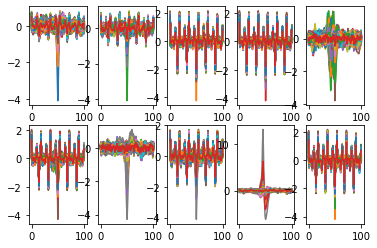

In [5]:
import matplotlib.pyplot as plt
for k in range(10):
    ax=plt.subplot(2,5,k+1)
    plt.plot(data[k])
plt.show()

(1000, 128, 160, 14)
